Hier alle imports gewoon plaatsen denk ik, zouden het ook kunnen doen per deel maar niet dat het in random codeblocks staat

# Objective of the Analysis

**Goal**:  
The primary goal of this analysis is to identify which factors significantly influence the **adoption of solar panels** on residential rooftops in municipalities across the Netherlands. By analysing various variables and their correlations with solar panel adoption, we aim to pinpoint the key drivers behind this adoption. These insights can support the development of targeted policies to accelerate the transition to renewable energy.

---

## Research Question

Which demographic, geographic, and housing-related variables have the strongest correlation with the adoption of solar panels in Dutch municipalities?

---

## Definition of Solar Panel Adoption

In this analysis, the adoption of solar panels is defined as:
- **The percentage of residential properties with installed solar panels in a municipality**:  


---

## Relevant Variables

We will examine the correlation of the adoption rate with the following variables:

2. **Housing Types**:
   - The distribution of detached houses, terraced houses, and apartments (woningtype.csv).
3. **Income**:
   - The average disposable income per household (IAPES.csv).
4. **Education Levels**:
   - The percentage of the population with various education levels (onderwijs.csv).
5. **Population Density**:
   - The number of residents per square kilometre in each municipality (gemeenten2021.csv).
6. **MORE TO COME**

---

## Expected Outcomes

By calculating the correlations between the variables and the solar panel adoption rate:
- Identify variables with a **strong positive correlation** (e.g., income or housing type).
- Highlight variables with a **negative correlation** or limited influence.
- Provide actionable insights to policymakers for encouraging solar panel adoption in targeted areas.

**Sources (CBS Statlines)**
- Bevolking = https://opendata.cbs.nl/#/CBS/nl/dataset/37230ned/table?dl=A564B 2019-2023 Niet gebruikt
- Inkomen = https://opendata.cbs.nl/#/CBS/nl/dataset/86005NED/table?dl=9552C 2021 Niet gebruikt
- Woningen = https://opendata.cbs.nl/#/CBS/nl/dataset/85035NED/table?dl=B40B6 2021
- Zonneenergie = https://opendata.cbs.nl/#/CBS/nl/dataset/85005NED/table?dl=B3FBC 2019-2021
- Gemeente namen = https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling-per-jaar/gemeentelijke-indeling-op-1-januari-2021
- Inkomen & Leeftijd & Bevolking & Onderwijs & oppervlaktes samen = https://opendata.cbs.nl/#/CBS/nl/dataset/70072ned/table?dl=B40C8 2019-2023 (Nu gebruikt)
- Dichtheid kan je uitrekenen met oppervlakte en woningen
- Missend zijn subsidie 
- Platte daken = https://www.atlasleefomgeving.nl/platte-daken-in-nederland-bag

IAPES (engels) wordt gebruikt voor de DF met Inkomen, leeftijd, Bevolking, onderwijs, oppervlaktes

In [30]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [31]:
# Path to the relevant geofiles
municipality_shapefile = "data/geo/gemeenten_2021_v3.shp"
provinces_shapefile = "data/geo/GRS_1000_PROV_NL_V.shp"

# Path to the relevant files
municipality_names_path = "data/gemeenten2021.csv"
housing_type_path = "data/woningtype_nieuw.csv"
solar_path = "data/zonnestroom.csv"
rooftop_path = "data/platdak.csv"
IAPES_path = "data/IAPES.csv"

In [32]:
# Reading the other datasets as DataFrames
municipality_names_df = pd.read_csv(municipality_names_path, header=0, delimiter=';')
housing_type_df = pd.read_csv(housing_type_path, header=0, delimiter=';')
solar_df = pd.read_csv(solar_path, header=0, delimiter=';')
rooftop_df = pd.read_csv(rooftop_path, header=0, delimiter=';')
IAPES_df = pd.read_csv(IAPES_path, header=0, delimiter=';')

Eerst gemeenten namen checken omdat die relevant zijn voor de andere files. 

In [33]:
# Dataframe voor alle gemeenten namen in 2021
display(municipality_names_df)

,Gemeentecode,GemeentecodeGM,Gemeentenaam,Provinciecode,ProvinciecodePV,Provincienaam
0,1680,GM1680,Aa en Hunze,22,PV22,Drenthe
1,358,GM0358,Aalsmeer,27,PV27,Noord-Holland
2,197,GM0197,Aalten,25,PV25,Gelderland
3,59,GM0059,Achtkarspelen,21,PV21,Fryslân
4,482,GM0482,Alblasserdam,28,PV28,Zuid-Holland
...,...,...,...,...,...,...
347,879,GM0879,Zundert,30,PV30,Noord-Brabant
348,301,GM0301,Zutphen,25,PV25,Gelderland
349,1896,GM1896,Zwartewaterland,23,PV23,Overijssel
350,642,GM0642,Zwijndrecht,28,PV28,Zuid-Holland


### Preprocessing
Na het checken van de gemeente namen, het inladen van de gpd file. Vervolgens willen we eerst alle water gebieden van de gemeenten eruit halen, anders krijg je ook het water gebied waar de gemeenten verantwoordelijk voor zijn. Voor merge kolom hernoemen, we mergen om te checken of alles consistent is dus zowel gemeentennamen shapefile vs het gemeentennamen bestand uit 2021. Checken we straks tegen mergedf

In [34]:
# Laad de shapefile met GeoPandas voor zowel gemeenten als provincien
gdf_municipalities = gpd.read_file(municipality_shapefile)
gdf_provinces = gpd.read_file(provinces_shapefile)

# Filter for only municipalities (no water) and the year 2021
filtered_gdf_municipalities = gdf_municipalities[(gdf_municipalities['H2O'] == 'NEE')]

# Reset the index
filtered_gdf_municipalities = filtered_gdf_municipalities.reset_index(drop=True)

# Hernoem de GM kolom voor mergen
municipality_names_df = municipality_names_df.rename(columns={'Gemeentenaam':'GM_NAAM'})

# Merge the filtered and unique GeoDataFrame with the municipality names DataFrame
gdf_municipalities_merged = filtered_gdf_municipalities.merge(
    municipality_names_df,
    on="GM_NAAM",
    how="inner"  # Ensures all rows from `municipality_names_df` are retained, checks if the names are the same
)

gdf_municipalities_merged.to_crs(epsg=4326, inplace=True)
gdf_provinces.to_crs(epsg=4326, inplace=True)

display(gdf_municipalities_merged)

,OBJECTID,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,...,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry,Gemeentecode,GemeentecodeGM,Provinciecode,ProvinciecodePV,Provincienaam
0,84.0,GM0014,Groningen,NEE,3312,1,1257,233273,116177,117096,...,2021GM0014,2021,98454.011519,1.979605e+08,"POLYGON ((6.74099 53.31197, 6.7413 53.31179, 6...",14,GM0014,20,PV20,Groningen
1,85.0,GM0034,Almere,NEE,1616,2,1662,214715,106523,108192,...,2021GM0034,2021,77001.560698,1.392038e+08,"MULTIPOLYGON (((5.21106 52.33159, 5.21107 52.3...",34,GM0034,24,PV24,Flevoland
2,86.0,GM0037,Stadskanaal,NEE,836,4,270,31754,15659,16095,...,2021GM0037,2021,64057.948253,1.199441e+08,"POLYGON ((7.01013 53.0737, 7.0127 53.07029, 7....",37,GM0037,20,PV20,Groningen
3,87.0,GM0047,Veendam,NEE,1007,3,361,27417,13700,13717,...,2021GM0047,2021,39605.318697,7.867884e+07,"POLYGON ((6.90368 53.12754, 6.90423 53.12748, ...",47,GM0047,20,PV20,Groningen
4,88.0,GM0050,Zeewolde,NEE,822,4,93,22879,11662,11217,...,2021GM0050,2021,98901.663241,2.525283e+08,"MULTIPOLYGON (((5.539 52.29363, 5.53912 52.293...",50,GM0050,24,PV24,Flevoland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,431.0,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,...,2021GM1966,2021,321301.166576,4.875998e+08,"MULTIPOLYGON (((6.28864 53.34051, 6.28885 53.3...",1966,GM1966,20,PV20,Groningen
348,432.0,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,...,2021GM1969,2021,99030.762281,3.688457e+08,"POLYGON ((6.29076 53.33842, 6.29082 53.33837, ...",1969,GM1969,20,PV20,Groningen
349,433.0,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,...,2021GM1970,2021,238426.959926,3.837930e+08,"MULTIPOLYGON (((6.18131 53.41465, 6.182 53.414...",1970,GM1970,21,PV21,Fryslân
350,434.0,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,...,2021GM1978,2021,88570.376691,1.915841e+08,"POLYGON ((4.93003 51.94875, 4.93013 51.94865, ...",1978,GM1978,28,PV28,Zuid-Holland


Provincie grenzen over de gemeente kaart leggen, probleem is alleen dat de provincie grenzen met water zijn, dit zorgt voor wat moeilijkheden mbt het plotten.

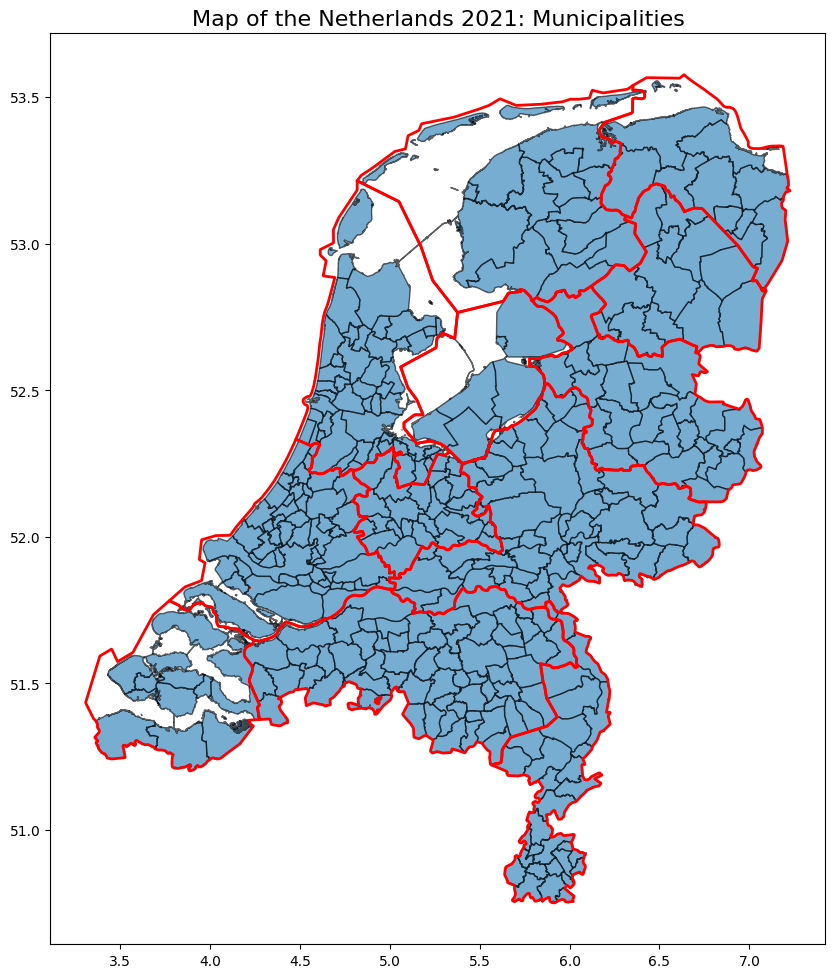

In [35]:
# Plot de kaart van Nederland met gemeenten en provinciën
fig, ax = plt.subplots(figsize=(10, 12))
gdf_municipalities_merged.plot(ax=ax, edgecolor='black', alpha=0.6)

# Overlay the provinces with red edges
gdf_provinces.plot(ax=ax, edgecolor='red', linewidth=2, facecolor="none")

plt.title("Map of the Netherlands 2021: Municipalities", fontsize=16)

plt.show()

In [24]:
display(housing_type_df)

,Regio's,Woningtype,Perioden,Beginstand woningvoorraad (aantal)
0,Nederland,Totaal woningen,2021,7966331.0
1,Nederland,Meergezinswoningen totaal,2021,2870532.0
2,Nederland,Eengezinswoningen totaal,2021,5095799.0
3,Nederland,Vrijstaande woning,2021,1035389.0
4,Nederland,2-onder-1-kapwoning,2021,698022.0
...,...,...,...,...
2859,Buitenland,Vrijstaande woning,2021,NaN
2860,Buitenland,2-onder-1-kapwoning,2021,NaN
2861,Buitenland,Hoekwoning,2021,NaN
2862,Buitenland,Tussenwoning,2021,NaN


In [36]:
# Get unique woningtypes from the 'Woningtype' column
unique_woningen = housing_type_df['Woningtype'].unique()

# Print the unique woningtypes
print("Unieke woningtypes in de kolom 'Woningtype':")
for woning in unique_woningen:
    print(woning)

Unieke woningtypes in de kolom 'Woningtype':
Totaal woningen
Meergezinswoningen totaal
Eengezinswoningen totaal
Vrijstaande woning
2-onder-1-kapwoning
Hoekwoning
Tussenwoning
Onbekend woningtype eengezinswoning


# Beschrijving van de Dataset

## Inhoud
De dataset bevat informatie over woningtypes in Nederland en hun aantallen per categorie. Het doel is om inzicht te geven in de verdeling van verschillende woningtypes en hun kenmerken, zoals het totale aantal woningen en de onderverdeling in specifieke categorieën.
### Belangrijke Kolommen
1. **Regio's**: De geografische regio's, zoals gemeenten of Nederland als geheel.
2. **Woningtype**: Het type woning.
3. **Perioden**: Het jaar waarop de data betrekking heeft (bijvoorbeeld 2021).
4. **Beginstand woningvoorraad (aantal)**: Het aantal woningen aan het begin van de periode.

#### **- Totaal woningen**
- **Type woning**: Overkoepelende categorie die alle woningtypes omvat, inclusief zowel eengezins- als meergezinswoningen.
- **Invloed op zonnepanelen**: Dit is een aggregaatcategorie, dus de invloed varieert afhankelijk van het specifieke woningtype.

#### **- Meergezinswoningen totaal**
- **Type woning**: Woningen in een gebouw dat meerdere huishoudens huisvest, zoals flats en appartementen.
- **Invloed op zonnepanelen**:
  - Het dak wordt gedeeld door meerdere huishoudens, waardoor individuele plaatsing niet mogelijk is.
  - Plaatsing vereist samenwerking via bijvoorbeeld een Vereniging van Eigenaren (VvE) of een collectief project.

#### **- Eengezinswoningen totaal**
- **Type woning**: Grondgebonden woningen bedoeld voor één huishouden, waaronder vrijstaande woningen, hoekwoningen, tussenwoningen en twee-onder-een-kapwoningen.
- **Invloed op zonnepanelen**:
  - Dak is meestal volledig in eigendom van het huishouden.
  - Ideaal voor individuele plaatsing van zonnepanelen zonder organisatorische beperkingen.

#### **- Vrijstaande woning**
- **Type woning**: Een woning die volledig vrijstaat, zonder gemeenschappelijke muren met andere woningen.
- **Invloed op zonnepanelen**:
  - Het hele dak is beschikbaar voor zonnepanelen.
  - Geen schaduw van aangrenzende gebouwen; maximale flexibiliteit in plaatsing.

#### **- 2-onder-1-kapwoning**
- **Type woning**: Twee woningen die samen één gebouw vormen en een gemeenschappelijke muur delen.
- **Invloed op zonnepanelen**:
  - Elk huishouden heeft zijn eigen dakhelft, wat zelfstandige plaatsing mogelijk maakt.
  - Dakoriëntatie kan verschillen per woning, wat de opbrengst kan beïnvloeden.

#### **- Hoekwoning**
- **Type woning**: Een woning aan het uiteinde van een rij, vaak met extra buitenruimte en een zijmuur.
- **Invloed op zonnepanelen**:
  - Dak is eigendom van de bewoner, zonder gedeelde eigendomsrechten.
  - Minder kans op schaduw van aangrenzende woningen, vooral aan de vrije zijde.

#### **- Tussenwoning**
- **Type woning**: Een woning die zich in het midden van een rij woningen bevindt, met muren aan beide zijden gedeeld met buren.
- **Invloed op zonnepanelen**:
  - Het dak is eigendom van de bewoner, maar de beschikbare ruimte is vaak beperkt.
  - Mogelijke schaduw van aangrenzende woningen kan de opbrengst beïnvloeden.

# Conclusie
Voor de analyse wordt onderscheid gemaakt tussen twee woningtypes: **Eengezinswoningen totaal** en **Meergezinswoningen totaal**

In [37]:
# Unstacking based on 'Woningtype'
housing_type_df = housing_type_df.pivot_table(
    index=["Regio's", 'Perioden'], 
    columns='Woningtype', 
    values='Beginstand woningvoorraad (aantal)'
).reset_index()

display(housing_type_df)

Woningtype,Regio's,Perioden,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0
...,...,...,...,...,...,...,...,...,...,...
348,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0
349,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0
350,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0
351,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0


In [38]:
display(housing_type_df)

Woningtype,Regio's,Perioden,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0
...,...,...,...,...,...,...,...,...,...,...
348,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0
349,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0
350,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0
351,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0


In [47]:
housing_type_filtered_df = housing_type_df[['Regio\'s','Perioden','Eengezinswoningen totaal','Meergezinswoningen totaal']]
display(housing_type_filtered_df)

Woningtype,Regio's,Perioden,Eengezinswoningen totaal,Meergezinswoningen totaal
0,'s-Gravenhage (gemeente),2021,56307.0,209652.0
1,'s-Hertogenbosch,2021,44343.0,29081.0
2,Aa en Hunze,2021,10262.0,945.0
3,Aalsmeer,2021,10389.0,2895.0
4,Aalten,2021,9893.0,2135.0
...,...,...,...,...
348,Zundert,2021,8420.0,1229.0
349,Zutphen,2021,15234.0,7417.0
350,Zwartewaterland,2021,7917.0,1096.0
351,Zwijndrecht,2021,12479.0,8241.0


In [198]:


display(solar_df)

,Sector en vermogensklasse,Regio's,Perioden,Installaties (aantal),Opgesteld vermogen van zonnepanelen (kWp),Opgesteld vermogen omvormers (kW),Productie van zonnestroom (mln kWh)
0,Woningen,Nederland,2019,960248.0,3236417.0,NaN,2620
1,Woningen,Nederland,2020,1267651.0,4488623.0,NaN,3714
2,Woningen,Nederland,2021,1611689.0,5843084.0,NaN,4652
3,Woningen,Nederland,2022,2131019.0,8014761.0,7619597.0,6760
4,Woningen,Aa en Hunze,2019,2573.0,10050.0,NaN,.
...,...,...,...,...,...,...,...
1443,Woningen,Zwolle,2022,18575.0,60879.0,58328.0,.
1444,Woningen,Gemeenten; niet in te delen,2019,352.0,792.0,NaN,1
1445,Woningen,Gemeenten; niet in te delen,2020,423.0,1460.0,NaN,1
1446,Woningen,Gemeenten; niet in te delen,2021,348.0,817.0,NaN,1


**Daken** 

In plaats van dakoriëntatie hebben we uiteindelijk gekozen voor het aantal platte daken per gemeente. Dit heeft twee redenen, ten eerste is hier een dataset voor, ten tweede stond in deze dataset ook voor gezinswoningen de hoeveelheid platte daken. Platte daken zijn interessant omdat juist hierop zonnepanelen maar ook daktuinen aangelegd kunnen worden door particulieren. Eerst worden de woningen gekozen met rooftop_df['Gebruiksfunctie'] == 'woonfunctie'. 

In [199]:
# Propagate 'Gemeentenaam 2021' downwards to fill NaN values
rooftop_df['Gemeentenaam 2021'] = rooftop_df['Gemeentenaam 2021'].fillna(method='ffill')

# Rename column to fit the common merge scheme
rooftop_df = rooftop_df.rename(columns={'Gemeentenaam 2021': "Regio's"})

# Drop the 'Gemeentenummer 2021' column
rooftop_df = rooftop_df.drop(columns=['Gemeentenummer 2021'])

# Only select homes since we are looking at consumer solar panels and possibilites
rooftop_homes_df = rooftop_df[rooftop_df['Gebruiksfunctie'] == 'woonfunctie']

rooftop_homes_df = rooftop_homes_df.reset_index(drop=True)

display(rooftop_homes_df)



C:\Users\juliu\AppData\Local\Temp\ipykernel_2392\3007145089.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rooftop_df['Gemeentenaam 2021'] = rooftop_df['Gemeentenaam 2021'].fillna(method='ffill')


,Regio's,Gebruiksfunctie,Geen plat dak (m2),Wel plat dak (m2),Onbekend (m2),Dakoppervlak totaal (m2)
0,Nederland,woonfunctie,392358906,155219511,8962633,556541051
1,Groningen (gemeente),woonfunctie,3220762,2531769,161576,5914107
2,Almere,woonfunctie,2529755,2332920,194086,5056762
3,Stadskanaal,woonfunctie,1242774,307563,23986,1574322
4,Veendam,woonfunctie,925117,248579,15320,1189016
...,...,...,...,...,...,...
348,Het Hogeland,woonfunctie,2842222,405148,48334,3295705
349,Westerkwartier,woonfunctie,2845242,512152,91725,3449119
350,Noardeast-Fryslân,woonfunctie,2104950,486412,22695,2614057
351,Molenlanden,woonfunctie,1298540,155674,26956,1481169


Origineel had de dataset voor de daken nog een paar niet matchende namen, zo stond er Utrecht, ipv Utrecht (gemeente), en stond er Bergen (NH) ipv Bergen (NH.) anders dan in de datasets van CBS. Dit is handmatig aangepast om zo the matchen. De andere kant op bevatten de cbs datasets nog gemeenten die al zijn opgeheven maar die worden er aan het einde pas uitgefilterd.

In [200]:
# Step 1: Find unmatched entries
unmatched_entries = rooftop_homes_df[~rooftop_homes_df["Regio's"].isin(solar_df["Regio's"])]
print(unmatched_entries["Regio's"].unique())

# Step 1: Find unmatched entries
unmatched_entries = solar_df[~solar_df["Regio's"].isin(rooftop_homes_df["Regio's"])]
print(unmatched_entries["Regio's"].unique())

[]
['Appingedam' 'Delfzijl' 'Dijk en Waard' 'Haaren' 'Land van Cuijk'
 'Loppersum' 'Maashorst' 'Voorne aan Zee' 'Gemeenten; niet in te delen']


In [201]:


IAPES_df.columns.tolist()

['Perioden',
 "Regio's",
 'Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/Jonger dan 5 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/5 tot 10 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/10 tot 15 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/15 tot 20 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/20 tot 25 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/25 tot 45 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/45 tot 65 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/65 tot 80 jaar (%)',
 'Bevolking/Bevolkingssamenstelling op 1 januari

In [202]:
# Filtering for 2021
housing_type_df_2021 = housing_type_df[housing_type_df['Perioden'] == 2021]
solar_df_2021 = solar_df[solar_df['Perioden'] == 2021]
IAPES_df_2021 = IAPES_df[IAPES_df['Perioden'] == 2021]

# Merging on 'Regio's'
merged_df = housing_type_df_2021.merge(
    solar_df_2021, on="Regio's", suffixes=('_housing', '_solar')
).merge(
    IAPES_df_2021, on="Regio's", suffixes=('', '_IAPES')
).merge(
    rooftop_homes_df, on="Regio's", suffixes=('', '_roofop')
)

Als je merged verlies je 1448/4=362 362-353 (kijk naar rij aantallen)=9 gemeenten, waaraan weet ik nog niet. Huisdata lijkt iig het minste aantal gemeenten te hebben, wel staan in veel oude cijfers gemeenten nog wel maar zonder data. Na een kleine google kom ik op 352 gemeenten nodig in 2021, en aangezien Nederland er ook bij zit klopt 353 precies (bron https://allecijfers.nl/definities/aantal-gemeenten-en-overzicht-gemeentelijkeherindelingen/)

In [203]:
display(merged_df)

,Regio's,Perioden_housing,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning,...,Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Totale oppervlakte (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Water totaal (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Binnenwater (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Buitenwater (km²),Gebruiksfunctie,Geen plat dak (m2),Wel plat dak (m2),Onbekend (m2),Dakoppervlak totaal (m2)
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0,...,98.13,82.45,15.68,3.08,12.6,woonfunctie,3479411,6196131,124872,9800414
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0,...,117.81,109.99,7.82,7.82,0.0,woonfunctie,2797987,1774831,68374,4641193
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0,...,278.87,276.09,2.79,2.79,0.0,woonfunctie,1409987,191469,20404,1621860
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0,...,32.29,20.12,12.17,12.17,0.0,woonfunctie,1178261,478024,22496,1678781
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0,...,97.05,96.54,0.52,0.52,0.0,woonfunctie,982240,151636,6484,1140360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0,...,121.21,120.65,0.56,0.56,0.0,woonfunctie,953450,199758,16033,1169241
349,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0,...,42.93,40.95,1.98,1.98,0.0,woonfunctie,1016290,344574,18178,1379042
350,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0,...,87.86,82.49,5.37,5.37,0.0,woonfunctie,716253,112728,12107,841088
351,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0,...,22.77,20.30,2.47,2.47,0.0,woonfunctie,754974,279630,11486,1046090


Toen ik probeerde te mergen tussen de geodf en merged_df kwam ik op 342 uit dus eerst check voor wat er anders is. In de unmatched entries kwam 292        Utrecht (gemeente)    boven, en nog veel andere zoals deze dit lijkt erop dat er bij de merged_df er sommigen gemeenten met () in staan. Vandaar de functie, zoals verwacht is nu alleen NL eruit geknald maar dat is prima. Nog een gevalletje was bergen wat zowel in NH als in L ligt, erg vervelend omdat deze dus wel in beiden goed staan vandaar dat ie eerst unmatched checked en dan stripped omdat die dus wel parentheses hebben en dat dat dus wel goed. Dan kom je precies op 352. Zonder exception matcht ie beiden aanelkaar dus dan heb je 2+2 4 bergens in je dataset 

In [204]:
# Hernoem de GM kolom voor mergen
merged_df = merged_df.rename(columns={"Regio's":'GM_NAAM'})

# Step 1: Find unmatched entries
unmatched_entries = merged_df[~merged_df["GM_NAAM"].isin(gdf_municipalities_merged["GM_NAAM"])]
print("Unmatched entries before stripping parentheses:")
print(unmatched_entries["GM_NAAM"].unique())

# Step 2: Function to strip parentheses
def strip_parentheses(name):
    return re.sub(r"\s*\(.*?\)", "", name).strip()

# Apply the function to unmatched entries only
merged_df.loc[unmatched_entries.index, "GM_NAAM"] = unmatched_entries["GM_NAAM"].apply(strip_parentheses)

# Step 3: Recheck unmatched entries after cleaning
unmatched_entries_after = merged_df[~merged_df["GM_NAAM"].isin(gdf_municipalities_merged["GM_NAAM"])]
print("Unmatched entries after stripping parentheses:")
print(unmatched_entries_after["GM_NAAM"].unique())

# Perform the merge
merged_df = merged_df.merge(
    gdf_municipalities_merged,
    on="GM_NAAM",
    how="inner"  # Ensures only matching rows are retained
)

display(merged_df)

Unmatched entries before stripping parentheses:
["'s-Gravenhage (gemeente)" 'Beek (L.)' 'Groningen (gemeente)'
 'Hengelo (O.)' 'Laren (NH.)' 'Middelburg (Z.)' 'Nederland'
 'Rijswijk (ZH.)' 'Stein (L.)' 'Utrecht (gemeente)']
Unmatched entries after stripping parentheses:
['Nederland']


,GM_NAAM,Perioden_housing,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning,...,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry,Gemeentecode,GemeentecodeGM,Provinciecode,ProvinciecodePV,Provincienaam
0,'s-Gravenhage,2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0,...,2021GM0518,2021,84316.880217,8.553474e+07,"MULTIPOLYGON (((4.19019 52.0588, 4.19137 52.05...",518,GM0518,28,PV28,Zuid-Holland
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0,...,2021GM0796,2021,70271.840396,1.178118e+08,"POLYGON ((5.43882 51.76503, 5.43916 51.76415, ...",796,GM0796,30,PV30,Noord-Brabant
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0,...,2021GM1680,2021,92666.919871,2.788749e+08,"POLYGON ((6.78406 53.08996, 6.78481 53.08949, ...",1680,GM1680,22,PV22,Drenthe
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0,...,2021GM0358,2021,32899.134056,3.228607e+07,"POLYGON ((4.82004 52.29435, 4.82095 52.29343, ...",358,GM0358,27,PV27,Noord-Holland
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0,...,2021GM0197,2021,52177.393258,9.705239e+07,"POLYGON ((6.56938 51.97223, 6.56968 51.97216, ...",197,GM0197,25,PV25,Gelderland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0,...,2021GM0879,2021,56698.523282,1.212072e+08,"POLYGON ((4.72056 51.54119, 4.72154 51.54065, ...",879,GM0879,30,PV30,Noord-Brabant
348,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0,...,2021GM0301,2021,43953.910643,4.293442e+07,"POLYGON ((6.19856 52.16299, 6.19871 52.16291, ...",301,GM0301,25,PV25,Gelderland
349,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0,...,2021GM1896,2021,55544.442583,8.705193e+07,"MULTIPOLYGON (((6.11003 52.65965, 6.10944 52.6...",1896,GM1896,23,PV23,Overijssel
350,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0,...,2021GM0642,2021,21357.281532,2.277474e+07,"POLYGON ((4.59883 51.83907, 4.59912 51.839, 4....",642,GM0642,28,PV28,Zuid-Holland


**Kolommen kiezen**
- Woningen = Meergezinswoningen totaal, Eengezinswoningen totaal, Totaal woningen
- Zonneenergie =     Opgesteld vermogen van zonnepanelen (kWp), Productie van zonnestroom (mln kWh)
- Jaartal = Perioden	
- Gemeente namen = GM_NAAM
- Inkomen & Leeftijd & Bevolking & Onderwijs & oppervlaktes samen = Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²)
- Platte daken = Wel plat dak (m2), Dakoppervlak totaal (m2)
- Ligging = geometry

In [205]:
df = merged_df[[ 
    "GM_NAAM",
    "Perioden",
    "Eengezinswoningen totaal", 
    "Meergezinswoningen totaal", 
    "Totaal woningen", 
    "Wel plat dak (m2)", 
    "Dakoppervlak totaal (m2)", 
    "Opgesteld vermogen van zonnepanelen (kWp)", 
    'Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)',
    "Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²)",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Voortgezet onderwijs (aantal)",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Middelbaar beroepsonderwijs (aantal)",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Hoger beroepsonderwijs bachelor (aantal)",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Wo master/doctoraal (aantal)",
    "Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld besteedbaar inkomen/Particuliere huishoudens excl. studenten (1 000 euro)",
    "geometry"
]]

display(df)

,GM_NAAM,Perioden,Eengezinswoningen totaal,Meergezinswoningen totaal,Totaal woningen,Wel plat dak (m2),Dakoppervlak totaal (m2),Opgesteld vermogen van zonnepanelen (kWp),Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²),Onderwijs/Naar woongemeente/Gediplomeerden/Voortgezet onderwijs (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Middelbaar beroepsonderwijs (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Hoger beroepsonderwijs bachelor (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Wo master/doctoraal (aantal),Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld besteedbaar inkomen/Particuliere huishoudens excl. studenten (1 000 euro),geometry
0,'s-Gravenhage,2021,56307.0,209652.0,265959.0,6196131,9800414,50252.0,548320.0,82.45,4530.0,4090.0,2148.0,1658.0,46.3,"MULTIPOLYGON (((4.19019 52.0588, 4.19137 52.05..."
1,'s-Hertogenbosch,2021,44343.0,29081.0,73424.0,1774831,4641193,46817.0,155490.0,109.99,1401.0,1196.0,720.0,238.0,50.0,"POLYGON ((5.43882 51.76503, 5.43916 51.76415, ..."
2,Aa en Hunze,2021,10262.0,945.0,11207.0,191469,1621860,16488.0,25399.0,276.09,245.0,252.0,91.0,17.0,51.8,"POLYGON ((6.78406 53.08996, 6.78481 53.08949, ..."
3,Aalsmeer,2021,10389.0,2895.0,13284.0,478024,1678781,10676.0,31991.0,20.12,405.0,227.0,87.0,30.0,61.4,"POLYGON ((4.82004 52.29435, 4.82095 52.29343, ..."
4,Aalten,2021,9893.0,2135.0,12028.0,151636,1140360,13035.0,27120.0,96.54,291.0,284.0,90.0,11.0,48.0,"POLYGON ((6.56938 51.97223, 6.56968 51.97216, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Zundert,2021,8420.0,1229.0,9649.0,199758,1169241,9763.0,21988.0,120.65,172.0,173.0,89.0,19.0,52.7,"POLYGON ((4.72056 51.54119, 4.72154 51.54065, ..."
348,Zutphen,2021,15234.0,7417.0,22651.0,344574,1379042,14779.0,48111.0,40.95,491.0,470.0,124.0,30.0,44.7,"POLYGON ((6.19856 52.16299, 6.19871 52.16291, ..."
349,Zwartewaterland,2021,7917.0,1096.0,9013.0,112728,841088,7199.0,22823.0,82.49,315.0,273.0,95.0,23.0,54.6,"MULTIPOLYGON (((6.11003 52.65965, 6.10944 52.6..."
350,Zwijndrecht,2021,12479.0,8241.0,20720.0,279630,1046090,10024.0,44775.0,20.30,463.0,390.0,103.0,36.0,47.1,"POLYGON ((4.59883 51.83907, 4.59912 51.839, 4...."


Explanation:
- "Municipality Name": Clear name for GM_NAAM column.
- "Year": Represents the period associated with the data.
- "Single-Family Homes Total" and "Multi-Family Homes Total": Logical split for housing types.
- "Total Homes": Overall total of all housing types.
- "Flat Roof Area (m2)" and "Total Roof Area (m2)": Dimensions related to roofing.
- "Installed Solar Capacity (kWp)": Solar energy-related details.
- "Land Area (km²)": Represents the land area in square kilometers.
- Education columns: Graduation numbers for various levels of education.
- "Average Disposable Income (1,000 EUR)": Represents household income excluding students.

In [206]:
# Renaming columns to logical names
df.rename(columns={
    "GM_NAAM": "Municipality Name",
    "Perioden": "Year",
    "Eengezinswoningen totaal": "Single-Family Homes Total",
    "Meergezinswoningen totaal": "Multi-Family Homes Total",
    "Totaal woningen": "Total Homes",
    "Wel plat dak (m2)": "Flat Roof Area (m2)",
    "Dakoppervlak totaal (m2)": "Total Roof Area (m2)",
    "Opgesteld vermogen van zonnepanelen (kWp)": "Installed Solar Capacity (kWp)",
    'Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)': 'Total Population',
    "Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²)": "Land Area (km2)",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Voortgezet onderwijs (aantal)": "Secondary Education",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Middelbaar beroepsonderwijs (aantal)": "Vocational Education",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Hoger beroepsonderwijs bachelor (aantal)": "Bachelor",
    "Onderwijs/Naar woongemeente/Gediplomeerden/Wo master/doctoraal (aantal)": "Master",
    "Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld besteedbaar inkomen/Particuliere huishoudens excl. studenten (1 000 euro)": "Average Disposable Income (1,000 EUR)",
    "geometry": "geometry"
}, inplace=True)

df= df.copy()

C:\Users\juliu\AppData\Local\Temp\ipykernel_2392\108396194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Municipality Name                      352 non-null    object  
 1   Year                                   352 non-null    int64   
 2   Single-Family Homes Total              352 non-null    float64 
 3   Multi-Family Homes Total               352 non-null    float64 
 4   Total Homes                            352 non-null    float64 
 5   Flat Roof Area (m2)                    352 non-null    int64   
 6   Total Roof Area (m2)                   352 non-null    int64   
 7   Installed Solar Capacity (kWp)         352 non-null    float64 
 8   Total Population                       352 non-null    float64 
 9   Land Area (km2)                        352 non-null    float64 
 10  Secondary Education                    352 non-null    float64

### Necessary formulas
1. Amount of Single-Family Homes (%) = Single-Family Homes Total / Total Homes * 100
2. Amount of Multi-Family Homes (%) = Multi-Family Homes Total / Total Homes * 100
3. Amount of Flat Roof Area (%) = Flat Roof Area (m2) / Total Roof Area (m2) * 100
4. Capacity relative to homes = Installed Solar Capacity (kWp) / Total Homes * 100
5. Population Density = Total Population / Land Area (km2)
6. Quantified Education = (Secondary Education * 1 + Vocational Education * 2 + Bachelor * 3 + Master * 4)
    / (Secondary Education + Vocational Education + Bachelor + Master)
7. Average Disposable Income (1,000 EUR) = Average Disposable Income (1,000 EUR)
8. Subsidies = 1 if province is Zuid-Holland else 0


Deel formule voor daken had dees te vroeg gemaakt

Wel plat dak (m2) / Dakoppervlak totaal (m2) * 100 = Platte daken op woningen per gemeente (%)


In [208]:
# Formula 1 amount of single family homes
df['Amount of Single-Family Homes (%)'] = (df['Single-Family Homes Total'] 
                                           / df['Total Homes']) * 100

# Formula 2 amount of multi family homes
df['Amount of Multi-Family Homes (%)'] = (df['Multi-Family Homes Total'] 
                                          / df['Total Homes']) * 100

# Formula 3 of the percentage of flat roofs in a municipality
df['Amount of Flat Roof Area (%)'] = df['Flat Roof Area (m2)'] / df['Total Roof Area (m2)'] * 100

# Formula 4 of the solar capacity per home
df['Capacity relative to homes'] = df['Installed Solar Capacity (kWp)'] / df['Total Homes'] * 100

# Formula 5 of the population density
df['Population Density'] = df['Total Population'] / df['Land Area (km2)']

# Formula 6 of the quantification of education, very much upto debate
df['Quantified Education'] = ((df['Secondary Education'] * 1 + df['Vocational Education'] * 2 + df['Bachelor'] * 3 + df['Master'] * 4) /
                              (df['Secondary Education'] + df['Vocational Education'] + df['Bachelor'] + df['Master'] ))

# Formula 8 of the subsidies per province
df['Subsidies'] = 0

# Keeping only the necessary columns
df = df[['Municipality Name', 'Year', 'geometry', 'Amount of Single-Family Homes (%)', 'Amount of Multi-Family Homes (%)', 'Amount of Flat Roof Area (%)',
         'Capacity relative to homes', 'Population Density', 'Quantified Education', 'Average Disposable Income (1,000 EUR)', 'Subsidies']]

display(df.head())




,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Capacity relative to homes,Population Density,Quantified Education,"Average Disposable Income (1,000 EUR)",Subsidies
0,'s-Gravenhage,2021,"MULTIPOLYGON (((4.19019 52.0588, 4.19137 52.05...",21.171308,78.828692,63.223156,18.894642,6650.333535,2.075165,46.3,0
1,'s-Hertogenbosch,2021,"POLYGON ((5.43882 51.76503, 5.43916 51.76415, ...",60.393059,39.606941,38.240836,63.762530,1413.673970,1.942335,50.0,0
2,Aa en Hunze,2021,"POLYGON ((6.78406 53.08996, 6.78481 53.08949, ...",91.567770,8.432230,11.805520,147.122334,91.995364,1.801653,51.8,0
3,Aalsmeer,2021,"POLYGON ((4.82004 52.29435, 4.82095 52.29343, ...",78.206865,21.793135,28.474470,80.367359,1590.009940,1.655541,61.4,0
4,Aalten,2021,"POLYGON ((6.56938 51.97223, 6.56968 51.97216, ...",82.249751,17.750249,13.297204,108.372132,280.919826,1.735207,48.0,0


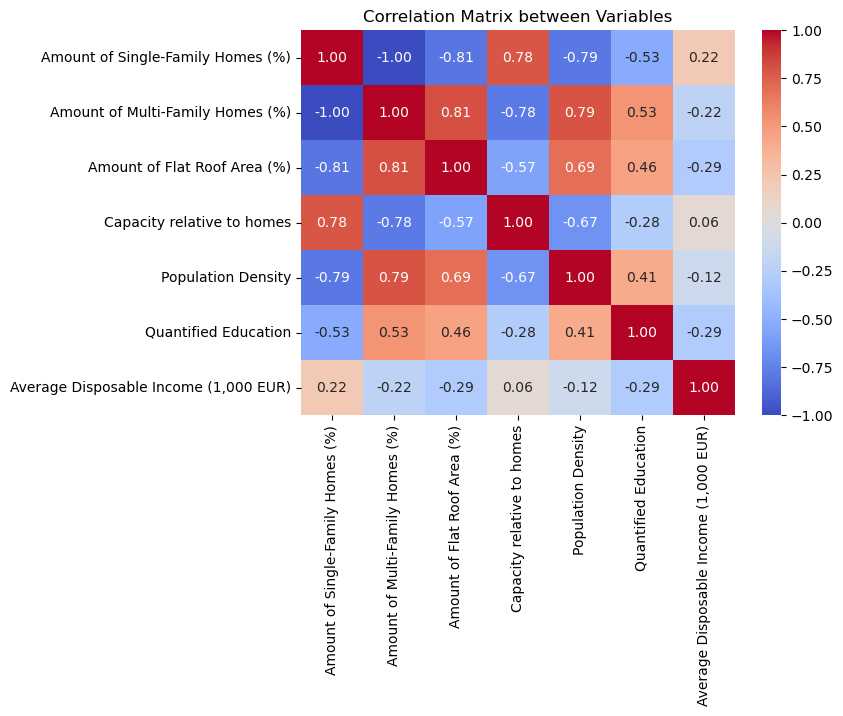

In [212]:
# List of columns
columns = ['Amount of Single-Family Homes (%)', 'Amount of Multi-Family Homes (%)', 'Amount of Flat Roof Area (%)',
         'Capacity relative to homes', 'Population Density', 'Quantified Education', 'Average Disposable Income (1,000 EUR)']

# Calculate the correlation matrix
corr_matrix = df[columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", cbar=True)
plt.title("Correlation Matrix between Variables")
plt.show()

In [214]:
df.sort_values('Quantified Education', ascending=True)[:5]

,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Capacity relative to homes,Population Density,Quantified Education,"Average Disposable Income (1,000 EUR)",Subsidies
251,Rozendaal,2021,"POLYGON ((6.0014 52.05504, 6.0011 52.05486, 6....",98.270893,1.729107,17.177228,181.268012,61.863799,1.310345,82.2,0
42,Bloemendaal,2021,"POLYGON ((4.61806 52.42484, 4.6181 52.42483, 4...",72.693291,27.306709,20.503151,50.216408,590.047751,1.476190,103.3,0
124,Heemstede,2021,"POLYGON ((4.60816 52.36296, 4.60819 52.36296, ...",64.851369,35.148631,23.462575,48.490286,3000.544662,1.518047,68.4,0
310,Vught,2021,"POLYGON ((5.24667 51.68322, 5.24687 51.68317, ...",77.473608,22.526392,22.777694,75.981070,527.377186,1.572108,64.2,0
166,Laren,2021,"POLYGON ((5.226 52.2679, 5.22613 52.2678, 5.22...",80.444771,19.555229,11.170627,28.377137,918.452861,1.575419,95.4,0


In [213]:
df.sort_values('Average Disposable Income (1,000 EUR)', ascending=False)[:5]

,Municipality Name,Year,geometry,Amount of Single-Family Homes (%),Amount of Multi-Family Homes (%),Amount of Flat Roof Area (%),Capacity relative to homes,Population Density,Quantified Education,"Average Disposable Income (1,000 EUR)",Subsidies
128,Heerlen,2021,"POLYGON ((5.92863 50.93635, 5.9287 50.93624, 5...",63.229090,36.770910,39.867251,57.237615,1934.490432,1.867477,37.6,0
156,Kerkrade,2021,"POLYGON ((6.07985 50.90488, 6.07993 50.90477, ...",63.884363,36.115637,39.185849,88.444667,2074.030123,1.799489,38.2,0
293,Vaals,2021,"POLYGON ((5.97567 50.80143, 5.97565 50.80115, ...",52.456201,47.543799,31.269651,64.084507,422.101298,1.830769,39.6,0
233,Pekela,2021,"POLYGON ((6.98117 53.11841, 6.98135 53.11831, ...",88.222068,11.777932,16.460071,90.591491,248.287113,1.749141,40.3,0
54,Brunssum,2021,"POLYGON ((5.97149 50.95972, 5.9723 50.95927, 5...",69.240874,30.759126,36.789488,75.159015,1604.057971,1.812383,40.7,0
